# Statoil/C-Core Iceberg Classifier Challenge

From October 2017 to January 2018 Kaggle hosted a competition in which participants were challenged to build machine learning algorithms to automatically detect whether an object on a satellite image is an iceberg or a ship. Details about the competition and the data can be found here:

https://www.kaggle.com/c/statoil-iceberg-classifier-challenge

I'm going to present my solution to this competition, which got me to rank 522 out of 3343 participants (top 16%).

At first all the necessary libraries are loaded.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split, StratifiedKFold
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Dropout, Convolution2D, Conv2D, MaxPooling2D, Lambda, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, AveragePooling2D, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils

%matplotlib inline
keras.backend.set_image_data_format('channels_last')

Using Theano backend.


## Load and explore data



The image data consists of two channels, 'band_1' and 'band_2', which are dB values. Band 1 and Band 2 are signals characterized by radar backscatter produced from different polarizations at a particular incidence angle. The polarizations correspond to HH (transmit/receive horizontally) and HV (transmit horizontally and receive vertically). For more information see here:

Background on satellite imagery:
https://www.kaggle.com/c/statoil-iceberg-classifier-challenge#Background

Data description:
https://www.kaggle.com/c/statoil-iceberg-classifier-challenge/data

In [2]:
def load_data(path, train_test = 'train'):
    '''
    path - path to the data
    train_test - What is loaded? Train or test data?
    '''
    
    data = pd.read_json(path)
    
    # There are a few missing incedence angles which are replaced by value 0.
    data.inc_angle = data.inc_angle.replace('na', 0)
    
    x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data["band_1"]])
    x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in data["band_2"]])
    
    # To use keras ImageDataGenerator later on we need 3-channel images, so create a third channel
    x_band3 = x_band1 / x_band2
    X = np.concatenate([x_band1[:, :, :, np.newaxis]
                        , x_band2[:, :, :, np.newaxis]
                        , x_band3[:, :, :, np.newaxis]], axis=-1)
    
    y = None
    ids = None
    if train_test == 'train':
        y = np.array(data["is_iceberg"])
    elif train_test == 'test':
        ids = np.array(data['ids'])
 
    
    return X, data["inc_angle"], y, ids


# set path to training data
path_train = 'train/train.json'

X_train, angle, y_train, _ = load_data(path_train, 'train')

We will quickly explore the data to get a sense of what it looks like, but won't dive into the analysis here too deeply.

How many images are there?

In [3]:
print('dimensions of X_train: ' + str(X_train.shape))
print('dimensions of y_train: ' + str(y_train.shape))
print('dimensions of angle: ' + str(angle.shape))

dimensions of X_train: (1604, 75, 75, 3)
dimensions of y_train: (1604,)
dimensions of angle: (1604,)


How many icebergs and ships are there?

In [4]:
print('Number of icebergs: ' + str(np.sum(y_train)))
print('Number of ships: ' + str(len(y_train) - np.sum(y_train)))

Number of icebergs: 753
Number of ships: 851


As there are approximately as many icebergs as ships we won't have to worry about class balancing.

### The images

To see what the images look like we plot a few examples of icebergs and ships.

In [5]:
def plot_images(images, num = 4, numrow = 1, numcol = 4, size = 4, title = None):
    '''
    input:
    images - numpy array of images
    num - number of plotted examples
    numrow - number of number of rows in subplot
    numcol - number of columns in subplot
    size - figure size
    title - title
    '''
    
    fig=plt.figure(figsize = (numcol * size, numrow * size))
    for i in range(num):
        ax1=fig.add_subplot(numrow, numcol, i+1)
        plt.imshow(images[i])
    fig.suptitle(title, size=20)

In [6]:
iceberg_ids = np.asarray(np.where(y_train == 1)).reshape(753,)
ship_ids = np.asarray(np.where(y_train == 0)).reshape(851,)

Choose 12 images of icebergs and ships randomly

In [7]:
# number of plotted examples each
num = 12
example_ice_ids = np.random.choice(iceberg_ids, num)
example_ship_ids = np.random.choice(ship_ids, num)

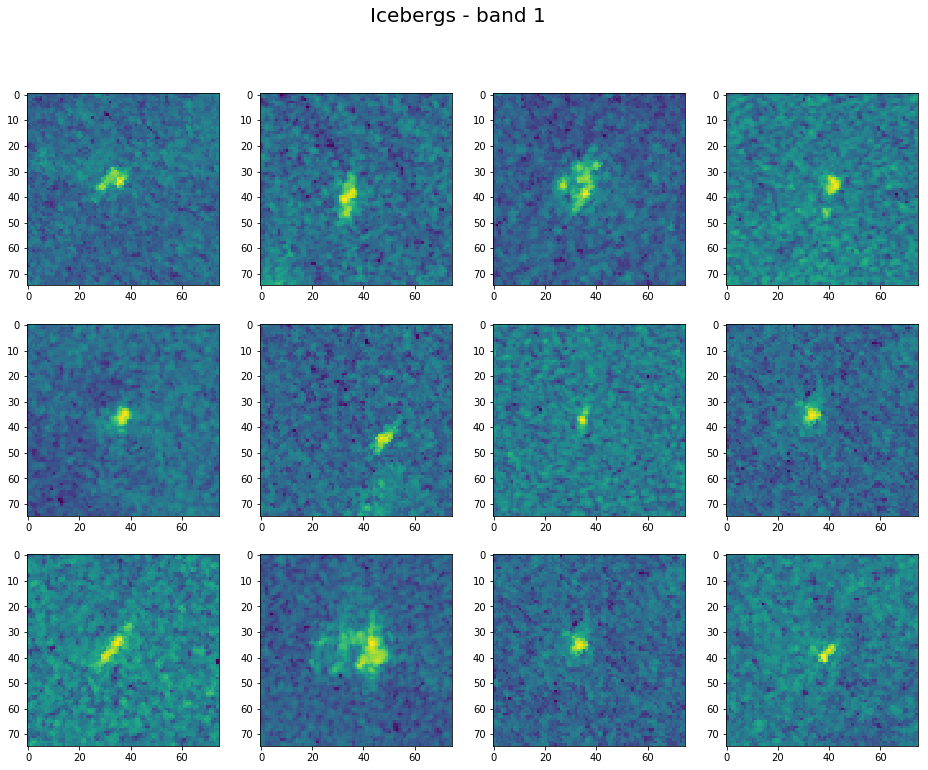

In [8]:
plot_images(X_train[example_ice_ids, :, :, 0], num, 3, 4, title = 'Icebergs - band 1')

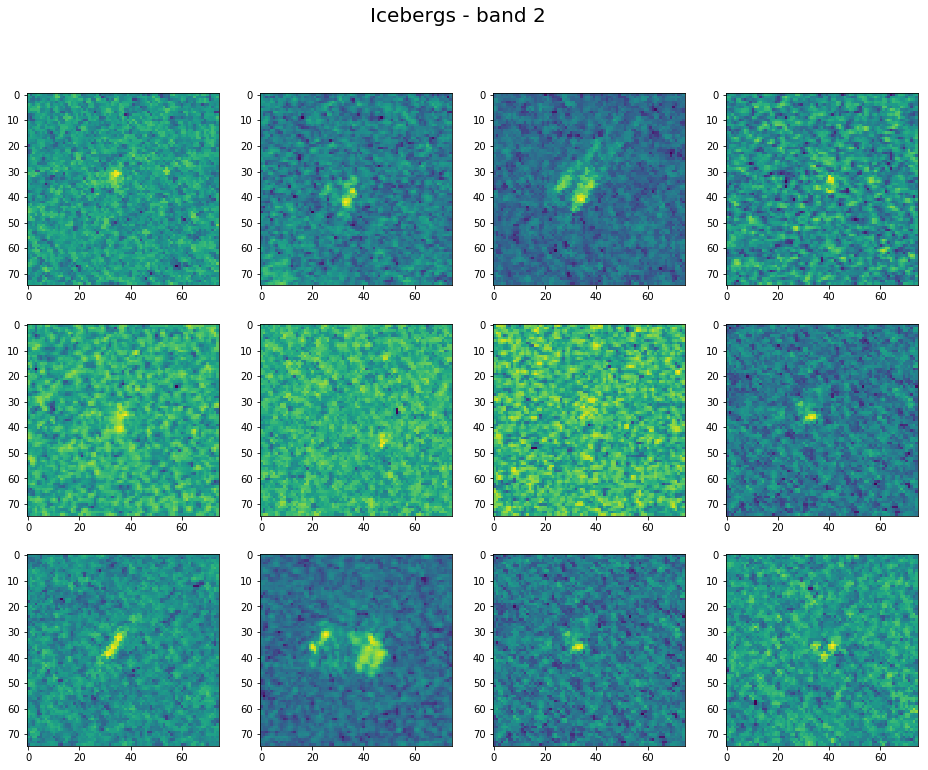

In [9]:
plot_images(X_train[example_ice_ids, :, :, 1], num, 3, 4, title = 'Icebergs - band 2')

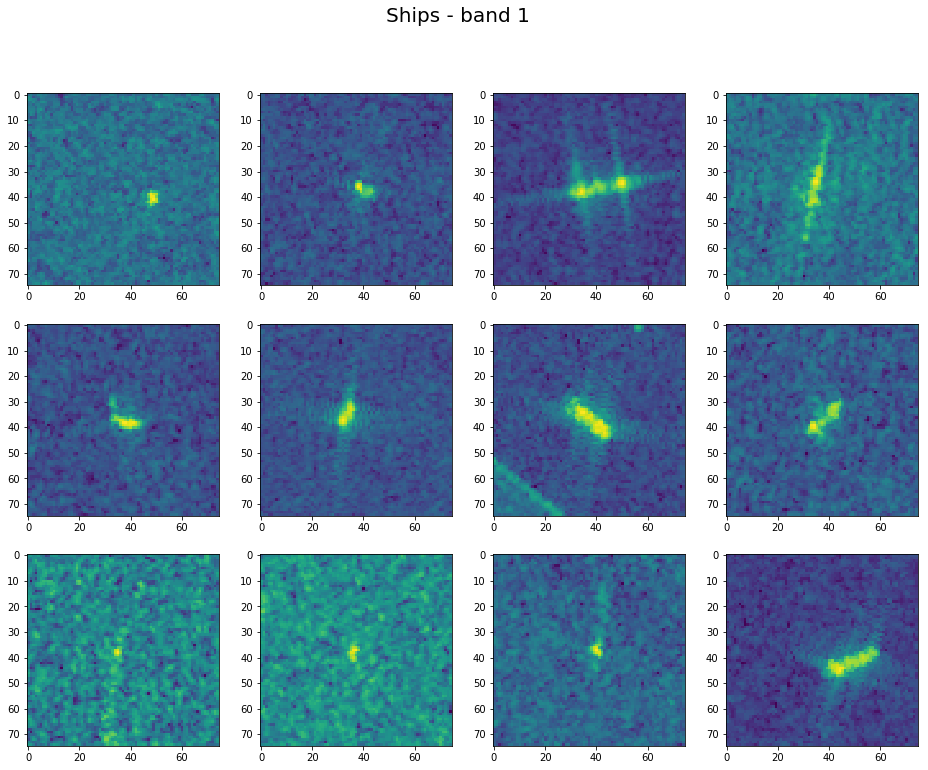

In [10]:
plot_images(X_train[example_ship_ids, :, :, 0], num, 3, 4, title = 'Ships - band 1')

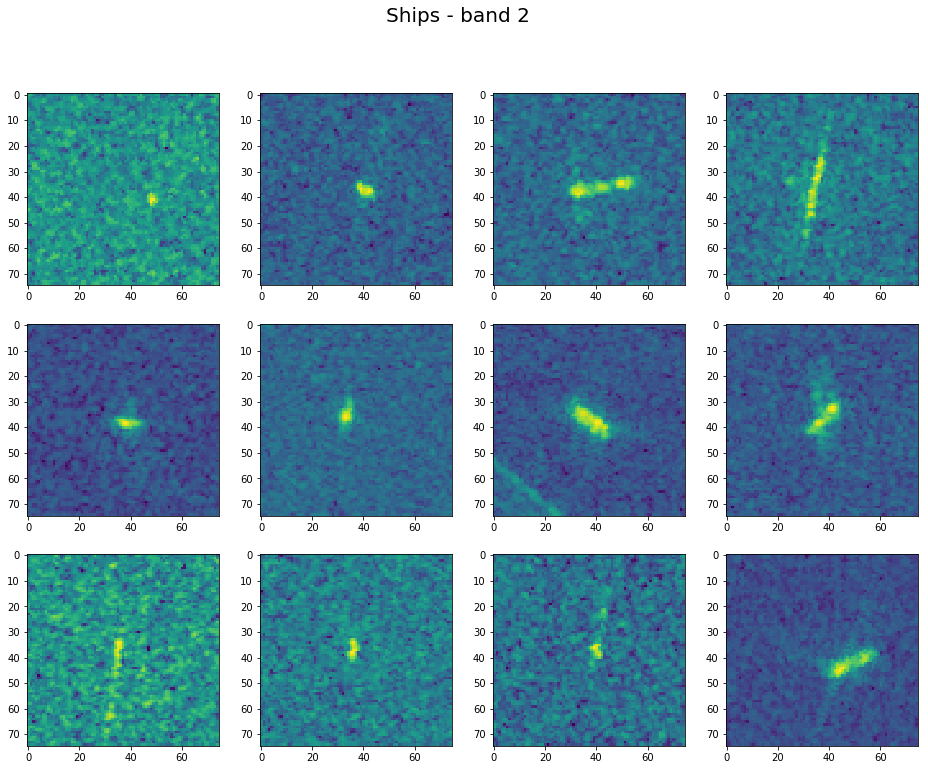

In [11]:
plot_images(X_train[example_ship_ids, :, :, 1], num, 3, 4, title = 'Ships - band 2')

### The incidence angle

Now let's take a look at the incidence angle.

<function matplotlib.pyplot.show>

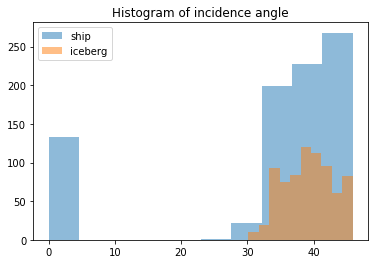

In [12]:
plt.hist(angle[ship_ids], alpha = 0.5, label = 'ship')
plt.hist(angle[iceberg_ids], alpha = 0.5, label = 'iceberg')
plt.legend(loc = 'upper left')
plt.title('Histogram of incidence angle')
plt.show

The mean of the incidence angle does not differ between icebergs and ships when leaving out the missing values that where replaced by zero.

In [13]:
print('mean of incidence angle for icebergs: ' + str(np.mean(angle[iceberg_ids])))
print('mean of incidence angle for ships: ' + str(np.mean(angle[angle>0][ship_ids])))

mean of incidence angle for icebergs: 39.24982058432939
mean of incidence angle for ships: 39.288515041782745


### K-Fold Cross Validation

For training the neural net the images are split into k folds for cross validation. This means the training set is split into k equally sized subsets. Then training is performed k times, each time with one of the possible combinations of k-1 subsets while one subset is left for validation. Here I decided to use k = 7 folds. The common choices like 5 or 10 folds didn't work quite as well, as with only 1604 training samples either training or validation set had been too small to yield both good training and stable validation results. Therefore I went with 7 folds as a compromise. 

In [14]:
k = 7
folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=1).split(X_train, y_train))

## Define and train model 

I tried several network architectures, and ended up using this rather small fully convolutional neural net with only about 170.000 trainable parameters. This had a better regularization effect than adding dropout layers, which is why I didn't use dropout at all. Instead I just decreased the model size with the positive side effect of a rather short training time.

This model can be trained on CPU only. One epoch took around 90 seconds.

In [15]:
def get_model():
    
    x = Input((75, 75, 3))
    model = BatchNormalization(axis = 3)(x)
    model = Convolution2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', activation='relu')(model)
    model = MaxPooling2D()(model)
    
    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', activation='relu')(model)
    model = MaxPooling2D()(model)
    
    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'same', activation='relu')(model)
    model = MaxPooling2D()(model)
    
    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', activation='relu')(model) 
    model = GlobalAveragePooling2D()(model)
 
    model = Dense(1, activation = 'sigmoid')(model)
    
    model = Model(input = x, output = model)
    
    opt_adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(opt_adam, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [16]:
model = get_model()
model.summary()

C:\Users\Stefanie\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=/input_1, outputs=sigmoid.0)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 3)         12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 37, 37, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
__________

### Data Augmentation

At first I tried heavy data augmentation to prevent overfitting. But I discovered that too much data augmentation hurt the performance. Eventually I found that the only slight image transformations that are defined here worked best for this problem.

In [17]:
batch_size = 64

gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 10
                        )

### Callbacks


I defined the following callbacks to:
* save only the weights with the best validation loss and
* reduce the learning rate by factor 0.1 if the training loss doesn't decrease for a to be specified number of epochs (default: 15)

In [18]:
def get_callbacks(name_weights, patience_lr = 15):
    mcp_save = ModelCheckpoint(name_weights, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, epsilon=1e-4, mode='min')
    return [mcp_save, reduce_lr_loss]

### Training and evaluation

The model is trained on each fold for 150 epochs. 

In [ ]:
for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\n===================FOLD=',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = y_train[train_idx]
    X_valid_cv = X_train[val_idx]
    y_valid_cv= y_train[val_idx]
    
    name_weights = "final_model_fold" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights)
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    model = get_model()
    model.fit_generator(
                generator,
                steps_per_epoch=len(X_train_cv)/batch_size,
                epochs=150,
                shuffle=True,
                verbose=1,
                validation_data = (X_valid_cv, y_valid_cv),
                callbacks = callbacks)

Now let's see how the model performs on each fold, i. e. each of the k validation sets.

In [19]:
for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFOLD =',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = y_train[train_idx]
    X_valid_cv = X_train[val_idx]
    y_valid_cv= y_train[val_idx]
    
    name_weights = "final_model_fold" + str(j) + "_weights.h5"
    model.load_weights(name_weights)
    print(model.evaluate(X_valid_cv, y_valid_cv))


FOLD = 0


WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


230/230 [==============================] - 4s     
[0.14145911342423895, 0.94347826086956521]

FOLD = 1
230/230 [==============================] - 4s     
[0.24785854090815004, 0.87391304347826082]

FOLD = 2
230/230 [==============================] - 4s     
[0.17807983211849046, 0.9260869570400404]

FOLD = 3
230/230 [==============================] - 4s     
[0.18719539642333985, 0.94347826086956521]

FOLD = 4
228/228 [==============================] - 4s     
[0.16655644205840012, 0.91666666666666663]

FOLD = 5
228/228 [==============================] - 4s     
[0.23192899687248364, 0.92105263157894735]

FOLD = 6
228/228 [==============================] - 4s     
[0.27470685025317626, 0.8771929824561403]


As we can see the validation losses and accuracies differ quite a lot between the folds. The validation loss ranges between 0.1415 and 0.2747. This has to be considered when the final model is ensembled.

### Including the incidence angle

Previously the incidence angle that was also given in the training data wasn't considered at all. To use this information as well, I added the incidence angle as a second input and concatenated it to the GlobalAveragePooling layer right before the output layer.

In [20]:
def get_model_angle():
    
    x = Input((75, 75, 3))
    model = BatchNormalization(axis = 3)(x)
    model = Convolution2D(filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', activation='relu')(model)
    model = MaxPooling2D()(model)
    
    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', activation='relu')(model)
    model = MaxPooling2D()(model)
       
    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = 'same', activation='relu')(model)
    model = MaxPooling2D()(model)
    
    model = BatchNormalization(axis = 3)(model)
    model = Convolution2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = 'same', activation='relu')(model) 
    model = GlobalAveragePooling2D()(model)
    
    x_angle = Input((1,))
    model = Concatenate()([model, x_angle])
    
    model = Dense(1, activation = 'sigmoid')(model)
    
    model = Model(input = [x, x_angle], output = model)
    
    opt_adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(opt_adam, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [21]:
model_angle = get_model_angle()
model_angle.summary()

C:\Users\Stefanie\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[/input_2,..., outputs=sigmoid.0)`


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
batch_normalization_5 (BatchNorm (None, 75, 75, 3)     12          input_2[0][0]                    
____________________________________________________________________________________________________
conv2d_5 (Conv2D)                (None, 75, 75, 32)    896         batch_normalization_5[0][0]      
____________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)   (None, 37, 37, 32)    0           conv2d_5[0][0]                   
___________________________________________________________________________________________

As I was running out of time towards the end of the competition, I trained this neural net only once, so no k-fold cross validation here. Instead I just used 85% of the data for training, leaving 15% for validation.

In [22]:
X_train, X_valid, y_train, y_valid, angle_train, angle_valid = train_test_split(X_train
                    , y_train, angle, random_state=1, train_size=0.85)

C:\Users\Stefanie\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


The keras ImageDataGenerator works by default for only one input. To use data augmentation with two inputs - the incidence angle is now the second input - I had to define a new generator. I used code from this kernel: https://www.kaggle.com/sinkie/keras-data-augmentation-with-multiple-inputs

In [23]:
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size,seed=5)
    genX2 = gen.flow(X1,X2, batch_size=batch_size,seed=5)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            yield [X1i[0], X2i[1]], X1i[1]

generator_angle = gen_flow_for_two_inputs(X_train, angle_train, y_train)

The model was also trained for 150 epochs:

In [24]:
callbacks = get_callbacks(name_weights = 'model_angle_weights_1.h5', patience_lr=15)

model_angle.fit_generator(generator_angle, epochs = 150, steps_per_epoch = len(X_train)/batch_size
                   , validation_data = ([X_valid, angle_valid], y_valid), callbacks = callbacks)

In [28]:
model_angle.load_weights('model_angle_weights_1.h5')

Let's see how the model performs on the validation set:

In [29]:
model_angle.evaluate([X_valid, angle_valid], y_valid)

241/241 [==============================] - 4s     


[0.14173026930123445, 0.94190871369294604]

## Prediction

Now the test set is loaded and predictions are made with the best models.

In [31]:
path_test = 'test/test.json'
X_test, angle_test, _, ids_test = load_data(path_test, 'test')

### Ensembling

Usually ensembling the predictions of different models yields better results than the prediction of a single model. That's why I used the different weights derived by k-fold cross validation of the first model (with no incidence angle) as well as the weights of the model with incidence angle to make predictions on the test set.

As we saw above not every fold gives good results. Therefore I only used the ones with a validation loss less than 0.2, which were folds 0, 2, 3 and 4.

In [34]:
num = 5  # number of models
pred_ensemb = 0
pred_matrix = np.zeros((num, len(X_test)))

print("Predicting with weights for...")

index = (0, 2, 3, 4)

for j in range(4):
    print("fold " + str(index[j]))
    model.load_weights('final_model_fold' + str(index[j]) + '_weights.h5')
    pred = model.predict(X_test)
    pred_matrix[j, ] = pred.T
    pred_ensemb = pred_ensemb + pred / num


print("model_angle")
model_angle.load_weights('model_angle_weights_1.h5')
pred = model_angle.predict([X_test, angle_test])
pred_matrix[4, ] = pred.T
pred_ensemb = pred_ensemb + pred / num


Predicting with weights for...
fold 0
fold 2
fold 3
fold 4
model_angle


Here we can see the correlation between the predictions. Although they are highly correlated (less correlated models give better results when ensembled), the ensembled model gave way better results on the leaderbord than the best single model.

In [35]:
np.corrcoef(pred_matrix)

array([[ 1.        ,  0.95955696,  0.94867344,  0.97031028,  0.95460021],
       [ 0.95955696,  1.        ,  0.95817154,  0.9577262 ,  0.9611836 ],
       [ 0.94867344,  0.95817154,  1.        ,  0.95295883,  0.96212872],
       [ 0.97031028,  0.9577262 ,  0.95295883,  1.        ,  0.95831063],
       [ 0.95460021,  0.9611836 ,  0.96212872,  0.95831063,  1.        ]])

For ensembling I used the idea of this kernel: https://www.kaggle.com/dongxu027/explore-stacking-lb-0-1463

In case all predictions are greater than 0.8, the maximal value is used. In case all predictions are smaller than 0.2, the minimal value is used. In all other cases, the median is used.
However, as it turned out when the competition was over and the private leaderbord was released, a simple ensembling with the mean of all predictions would have yielded slightly better results.

In [36]:
pred_stack = np.where(np.all(pred_matrix > 0.8, axis = 0)
                , np.amax(pred_matrix, axis = 0)
                , np.where(np.all(pred_matrix < 0.2, axis = 0)
                            , np.amin(pred_matrix, axis = 0)
                            , np.median(pred_matrix, axis = 0))
                )

### Create submission

In [37]:
submission = pd.DataFrame()
submission['id'] = ids_test 
submission['is_iceberg'] = pred_stack
submission.to_csv('submission_180117.csv', index=False)

## What didn't work

There were a few more things I tried that unfortunately didn't give me better results. Yet I want to still mention them here:
* Preprocessing the images with Gaussian or Bilateral filters: As some of the images were quite noisy, I tried smoothing the images while preserving the edges. This didn't improve the performance. I believe that is because the CNN already learns the filters it needs to classify the images. So by applying my own filters before the network has a chance to see the original images, I only loose information. 
* Pseudo labeling: I tried using hard and soft targets. For hard targets I tried different thresholds (0.5, 0.8, 0.9, 0.95) for the predictions, i. e. assigning label 1 to a test image if the prediction (model output) is greater than the threshold and label 0 if the prediction is smaller than 1-threshold. All of these versions only worsened the score.
* Finetuning the model on small objects: From looking at the predictions of the model on the validation set it was clear that the model had most difficulties with very small objects. So I picked the images with the smallest objects by calculating their area and tried to finetune the model on only these samples. Unfortunately it didn't help the performance at all. 
* Replacing the nan-values of the incidence angle with the mean of the incidence angles of ships: For some of the training samples the incidence angle was missing. All of these samples were ships, so I tried replacing the missing values with the mean of the incidence angle of all ships. It improved the performace locally a bit, but not the score on the leaderbord. 